In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from utils.utils import plot_metric

tqdm.pandas()

pd.set_option("display.width", 1000)
pd.options.mode.chained_assignment = None
hp_columns = ["embed_model", "llm", "chunk_size", "top_k", "rerank_model"]

data_retrieval = pd.read_csv("eval-retrieval-gpt-4o_context_relevance_with_cot-2025-06-09_18_52_33.csv")
data_gen = pd.read_csv("eval-full-judgement-ref-free-cr-ar-gr.csv")

Failure rate of Judges

In [2]:
for col in [
    col
    for col in data_retrieval.columns
    if ("judgement" in col or "relevance" in col or "groundedness" in col) and "_meta" not in col
]:
    fails = 0
    df_f = data_retrieval[(data_retrieval[col].isna()) | (data_retrieval[col] == -1)]
    print(f"Failure rate of {col}: {len(df_f) / len(data_retrieval)}")
for col in [
    col
    for col in data_gen.columns
    if ("judgement" in col or "relevance" in col or "groundedness" in col) and "_meta" not in col
]:
    fails = 0
    df_f = data_gen[(data_gen[col].isna()) | (data_gen[col] == -1)]
    print(f"Failure rate of {col}: {len(df_f) / len(data_gen)}")

Failure rate of gpt-4o_context_relevance_with_cot: 0.007395833333333333
Failure rate of mistralai--mistral-large-instruct_judgement: 0.0
Failure rate of gpt-4o_context_relevance_with_cot: 0.01
Failure rate of anthropic--claude-3.7-sonnet_answer_relevance_with_cot: 0.0
Failure rate of mistralai--mistral-large-instruct_judgement_ref_free: 0.0
Failure rate of anthropic--claude-3.7-sonnet_groundedness_filter_trivial: 0.0035


# 1. Retrieval Evaluation

Hyperparameter Combinations

In [3]:
for col in hp_columns:
    print(f"{col.upper()}: {'; '.join([str(s) for s in data_retrieval[col].unique()])}")

print(f"\nNumber of Data Points evaluated: {data_retrieval.shape[0]}")

EMBED_MODEL: BAAI/bge-m3; intfloat/multilingual-e5-large
LLM: nan
CHUNK_SIZE: 64; 128; 256; 512
TOP_K: 2; 4; 6; 8; 10; 12
RERANK_MODEL: nan; hooman650/bge-reranker-v2-m3-onnx-o4; mixedbread-ai/mxbai-rerank-base-v1; mixedbread-ai/mxbai-rerank-xsmall-v1

Number of Data Points evaluated: 9600


## 1.1 Retrieval Recall

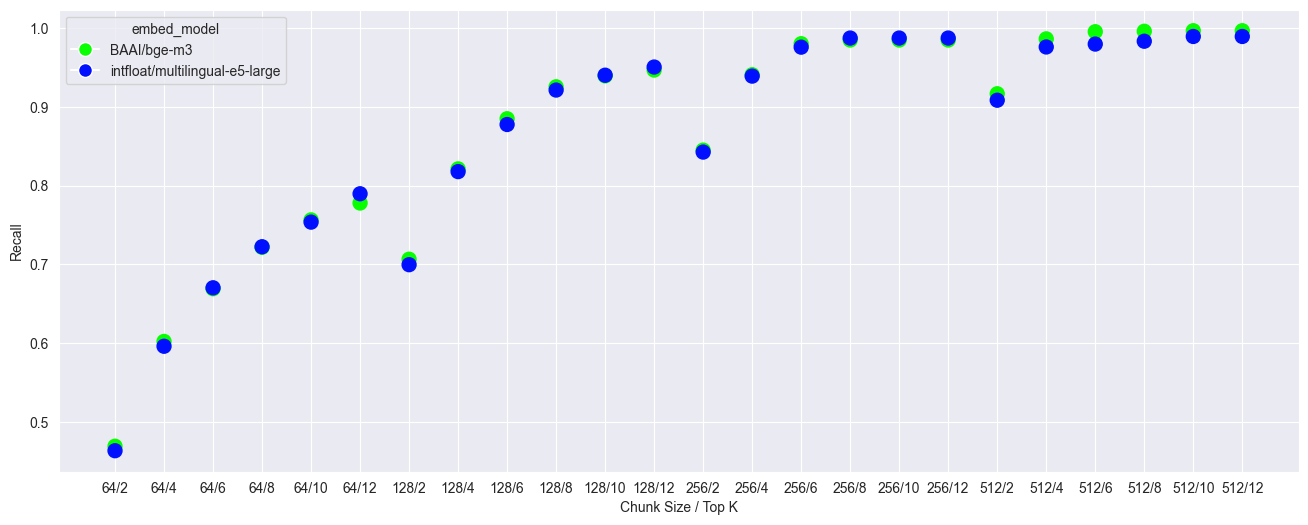

                      embed_model  mean_nodes_recall_0.5
0                     BAAI/bge-m3               0.867761
1  intfloat/multilingual-e5-large               0.864399


In [4]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "nodes_recall_0.5",
    "embed_model",
    "Chunk Size / Top K",
    "Recall",
    "",
)

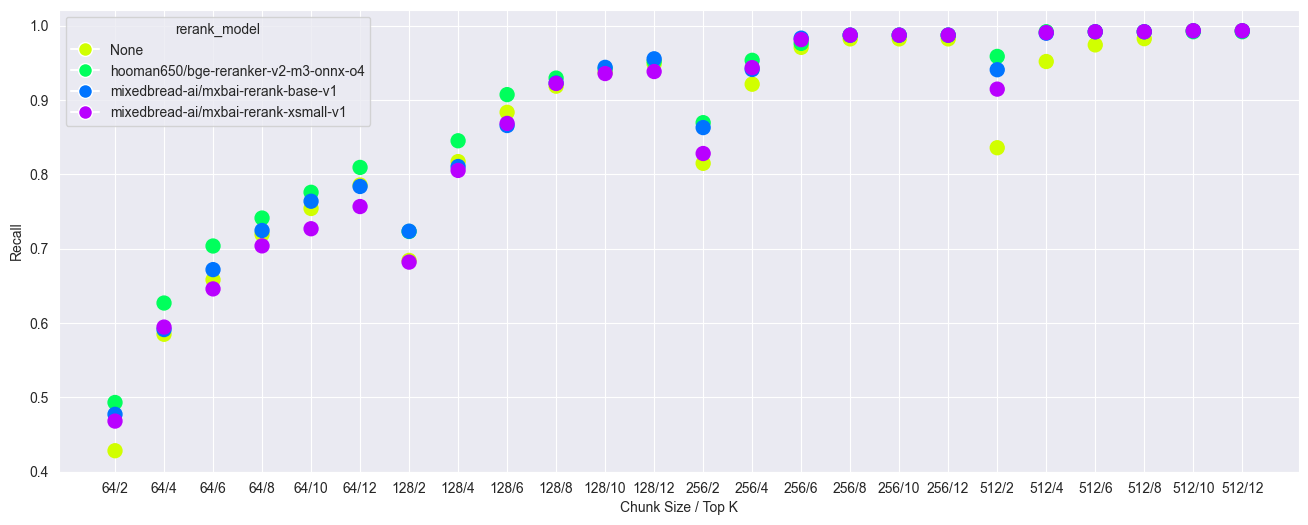

                           rerank_model  mean_nodes_recall_0.5
1  hooman650/bge-reranker-v2-m3-onnx-o4               0.880235
2    mixedbread-ai/mxbai-rerank-base-v1               0.870065
3  mixedbread-ai/mxbai-rerank-xsmall-v1               0.859809
0                                  None               0.854212


In [5]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "nodes_recall_0.5",
    "rerank_model",
    "Chunk Size / Top K",
    "Recall",
    "",
)

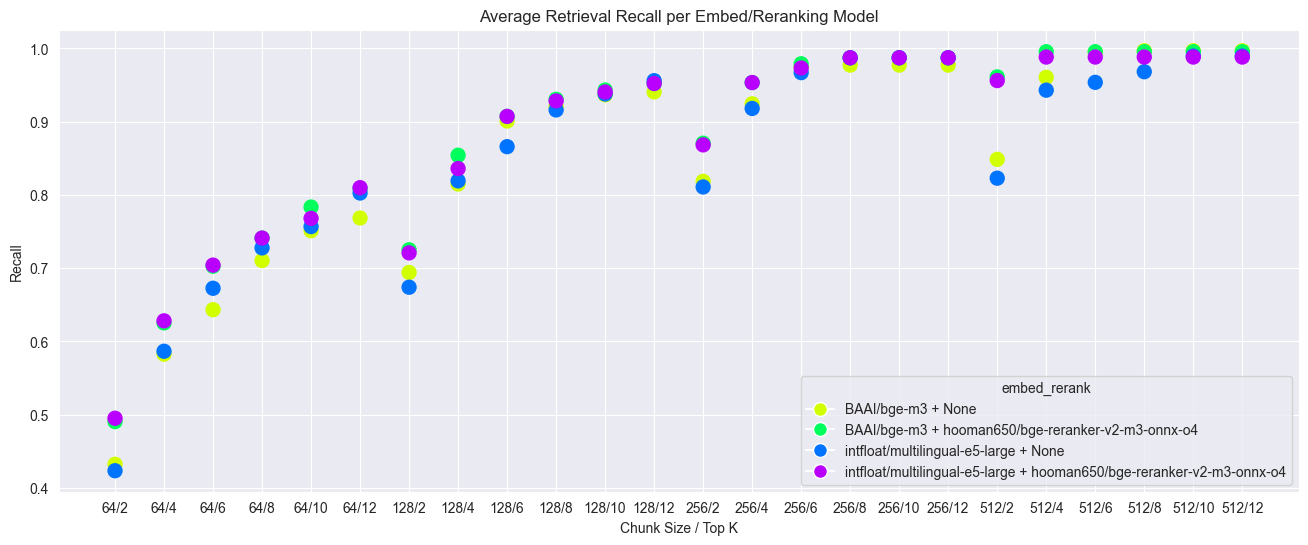

                                        embed_rerank  mean_nodes_recall_0.5
1  BAAI/bge-m3 + hooman650/bge-reranker-v2-m3-onn...               0.881942
3  intfloat/multilingual-e5-large + hooman650/bge...               0.878527
0                                 BAAI/bge-m3 + None               0.855824
2              intfloat/multilingual-e5-large + None               0.852600


In [6]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "nodes_recall_0.5",
    "embed_rerank",
    "Chunk Size / Top K",
    "Recall",
    "Average Retrieval Recall per Embed/Reranking Model",
    exclude_small_rerank=True,
)

Best combinations

In [7]:
group = data_retrieval.groupby(["embed_model", "rerank_model", "chunk_size", "top_k"], as_index=False, dropna=False)[
    "nodes_recall_0.5"
].mean()
print(group.nlargest(60, columns=["nodes_recall_0.5"]))

                        embed_model                          rerank_model  chunk_size  top_k  nodes_recall_0.5
70                      BAAI/bge-m3  mixedbread-ai/mxbai-rerank-xsmall-v1         512     10          0.996803
71                      BAAI/bge-m3  mixedbread-ai/mxbai-rerank-xsmall-v1         512     12          0.996803
46                      BAAI/bge-m3    mixedbread-ai/mxbai-rerank-base-v1         512     10          0.996791
47                      BAAI/bge-m3    mixedbread-ai/mxbai-rerank-base-v1         512     12          0.996791
93                      BAAI/bge-m3                                   NaN         512      8          0.996791
94                      BAAI/bge-m3                                   NaN         512     10          0.996791
95                      BAAI/bge-m3                                   NaN         512     12          0.996791
19                      BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         512      4          0.995442
2

## 1.2 Context Relevance

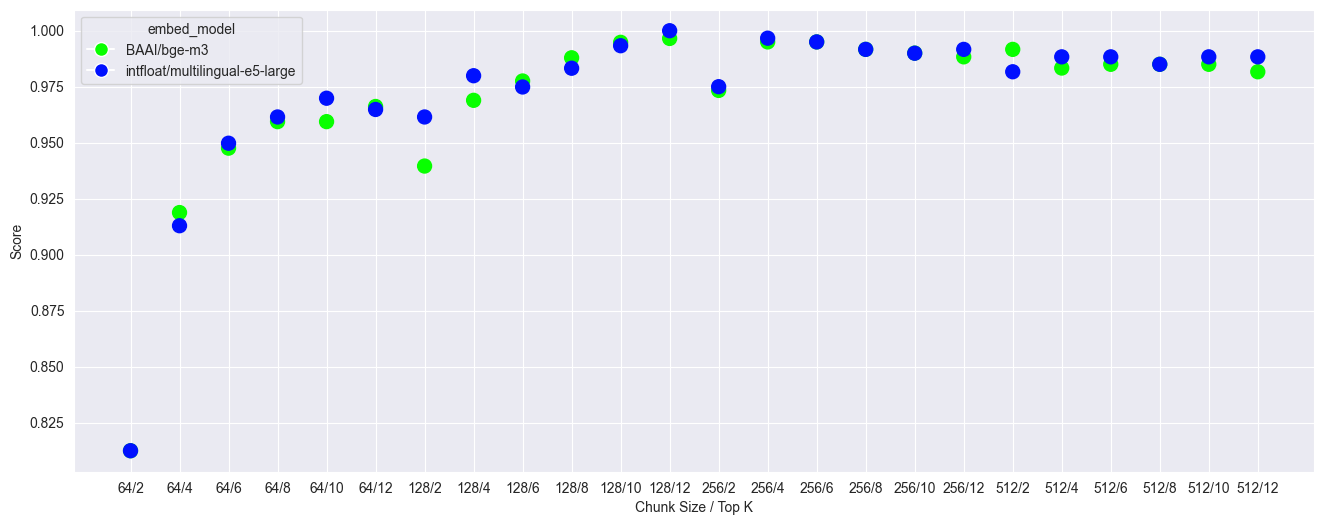

                      embed_model  mean_gpt-4o_context_relevance_with_cot
1  intfloat/multilingual-e5-large                                0.971831
0                     BAAI/bge-m3                                0.969748


In [8]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "gpt-4o_context_relevance_with_cot",
    "embed_model",
    "Chunk Size / Top K",
    "Score",
    "",
)

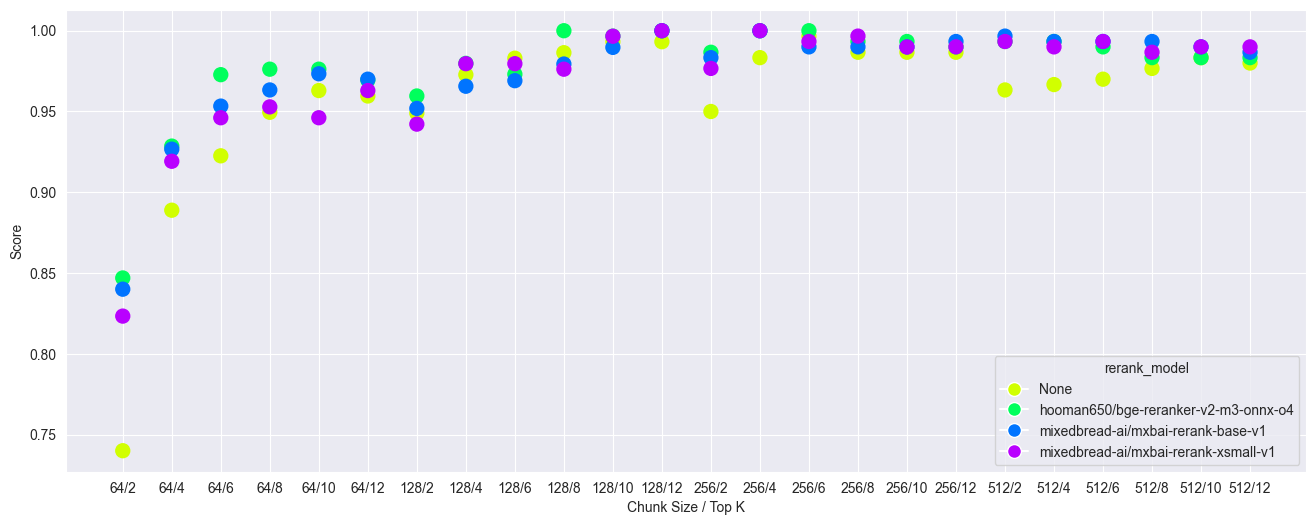

                           rerank_model  mean_gpt-4o_context_relevance_with_cot
1  hooman650/bge-reranker-v2-m3-onnx-o4                                0.977882
2    mixedbread-ai/mxbai-rerank-base-v1                                0.974264
3  mixedbread-ai/mxbai-rerank-xsmall-v1                                0.971444
0                                  None                                0.959627


In [9]:
plot_metric(
    data_retrieval,
    "chunk_top_k",
    "gpt-4o_context_relevance_with_cot",
    "rerank_model",
    "Chunk Size / Top K",
    "Score",
    "",
)

Best combinations

In [10]:
group = data_retrieval.groupby(["embed_model", "rerank_model", "chunk_size", "top_k"], as_index=False, dropna=False)[
    "gpt-4o_context_relevance_with_cot"
].mean()
print(group.nlargest(30, columns=["gpt-4o_context_relevance_with_cot"]))

                        embed_model                          rerank_model  chunk_size  top_k  gpt-4o_context_relevance_with_cot
9                       BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         128      8                           1.000000
10                      BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         128     10                           1.000000
11                      BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         128     12                           1.000000
13                      BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         256      4                           1.000000
14                      BAAI/bge-m3  hooman650/bge-reranker-v2-m3-onnx-o4         256      6                           1.000000
35                      BAAI/bge-m3    mixedbread-ai/mxbai-rerank-base-v1         128     12                           1.000000
37                      BAAI/bge-m3    mixedbread-ai/mxbai-rerank-base-v1         256      4            

In [11]:
r = data_retrieval.groupby("chunk_size")["gpt-4o_context_relevance_with_cot"].mean()
print(r)

chunk_size
64     0.927810
128    0.979875
256    0.988611
512    0.985972
Name: gpt-4o_context_relevance_with_cot, dtype: float64


## 1.3 Correlation between Recall and Context Relevance

In [12]:
print(data_retrieval["gpt-4o_context_relevance_with_cot"].corr(data_retrieval["nodes_recall_0.5"]))

0.4648913987846729


# 2. Generation evaluation
Hyperparameter combinations

In [13]:
for col in hp_columns:
    print(f"{col.upper()}: {'; '.join([str(s) for s in data_gen[col].unique()])}")

print(f"\nNumber of Data Points evaluated: {data_gen.shape[0]}")

EMBED_MODEL: BAAI/bge-m3
LLM: gemini-2.0-flash; gpt-4o; meta--llama3.1-70b-instruct; mistralai--mistral-large-instruct
CHUNK_SIZE: 128; 256; 512
TOP_K: 4; 6; 8; 10; 12
RERANK_MODEL: nan; hooman650/bge-reranker-v2-m3-onnx-o4

Number of Data Points evaluated: 6000


## 2.1 LLM-as-a-Judge

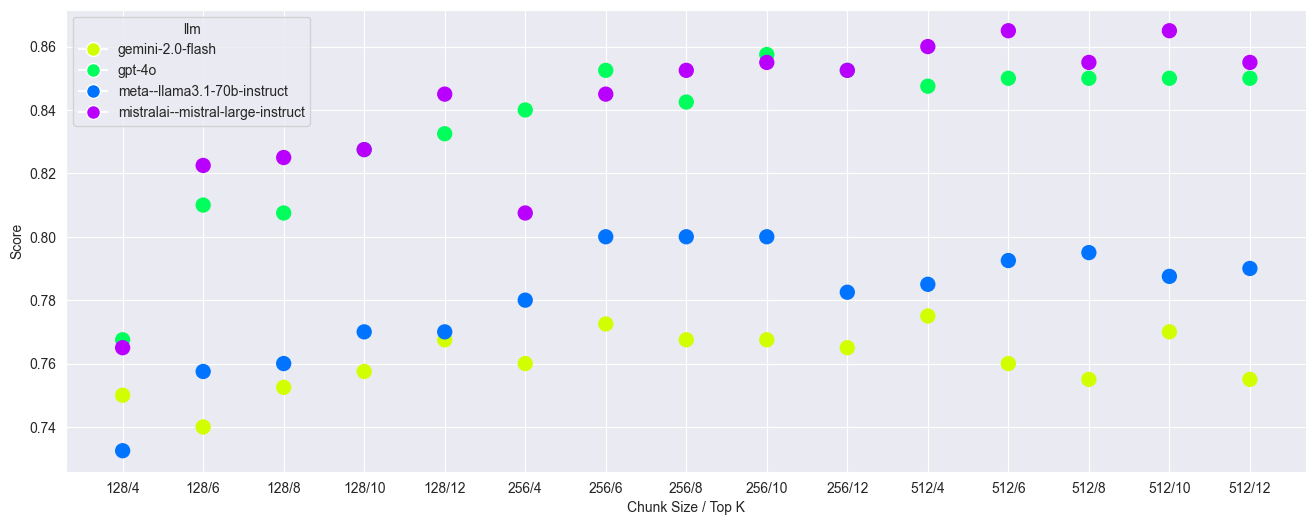

                                 llm  mean_mistralai--mistral-large-instruct_judgement
3  mistralai--mistral-large-instruct                                          0.839833
1                             gpt-4o                                          0.835833
2        meta--llama3.1-70b-instruct                                          0.780167
0                   gemini-2.0-flash                                          0.761000


In [14]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "mistralai--mistral-large-instruct_judgement",
    "llm",
    "Chunk Size / Top K",
    "Score",
    "",
)

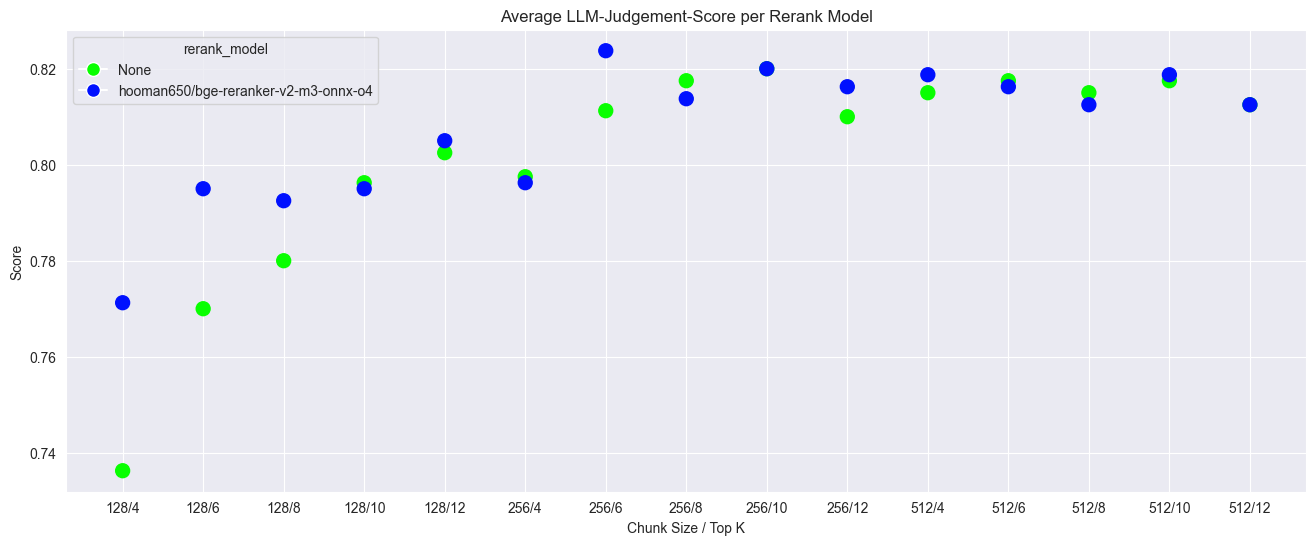

                           rerank_model  mean_mistralai--mistral-large-instruct_judgement
1  hooman650/bge-reranker-v2-m3-onnx-o4                                          0.807167
0                                  None                                          0.801250


In [15]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "mistralai--mistral-large-instruct_judgement",
    "rerank_model",
    "Chunk Size / Top K",
    "Score",
    "Average LLM-Judgement-Score per Rerank Model",
)

Best combinations

In [16]:
group = data_gen.groupby(["llm", "chunk_size", "top_k", "rerank_model"], as_index=False, dropna=False)[
    "mistralai--mistral-large-instruct_judgement"
].mean()
print(group.nlargest(10, columns=["mistralai--mistral-large-instruct_judgement"]))

                                   llm  chunk_size  top_k                          rerank_model  mistralai--mistral-large-instruct_judgement
119  mistralai--mistral-large-instruct         512     12                                   NaN                                        0.870
48                              gpt-4o         256     12  hooman650/bge-reranker-v2-m3-onnx-o4                                        0.865
110  mistralai--mistral-large-instruct         512      4  hooman650/bge-reranker-v2-m3-onnx-o4                                        0.865
112  mistralai--mistral-large-instruct         512      6  hooman650/bge-reranker-v2-m3-onnx-o4                                        0.865
113  mistralai--mistral-large-instruct         512      6                                   NaN                                        0.865
116  mistralai--mistral-large-instruct         512     10  hooman650/bge-reranker-v2-m3-onnx-o4                                        0.865
117  mistrala

## 2.1a Reference-free LLM-Judgement

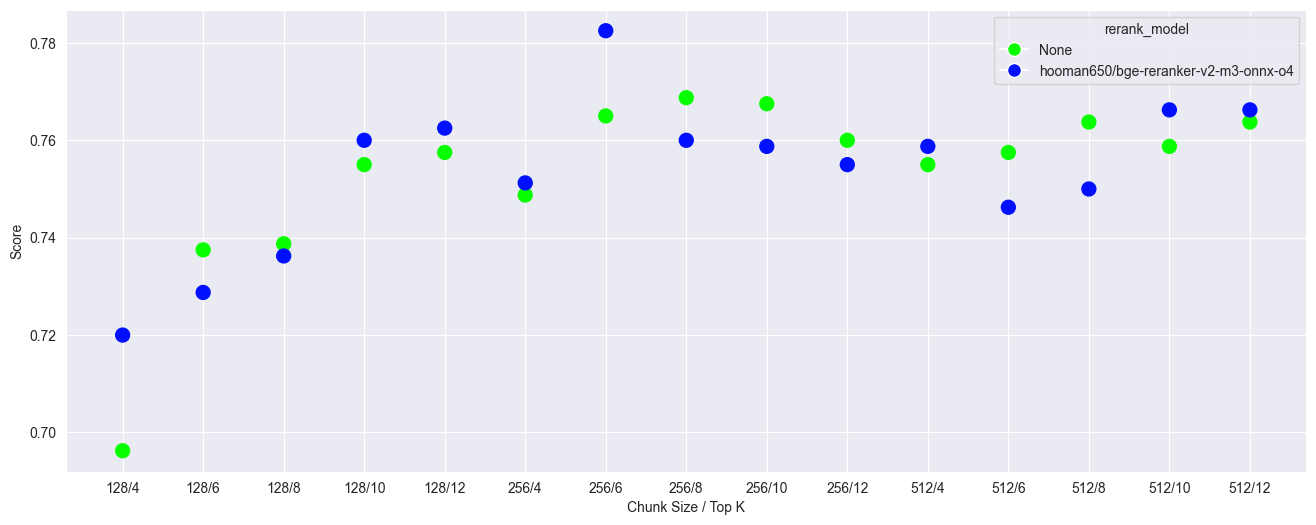

                           rerank_model  mean_mistralai--mistral-large-instruct_judgement_ref_free
1  hooman650/bge-reranker-v2-m3-onnx-o4                                           0.753500        
0                                  None                                           0.752917        


In [17]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "mistralai--mistral-large-instruct_judgement_ref_free",
    "rerank_model",
    "Chunk Size / Top K",
    "Score",
    "",
)

## 2.2 Legacy Metrics
Now lets check three legacy metrics: BLEU, ROUGE and BERT-Score
### 2.2.1 BLEU

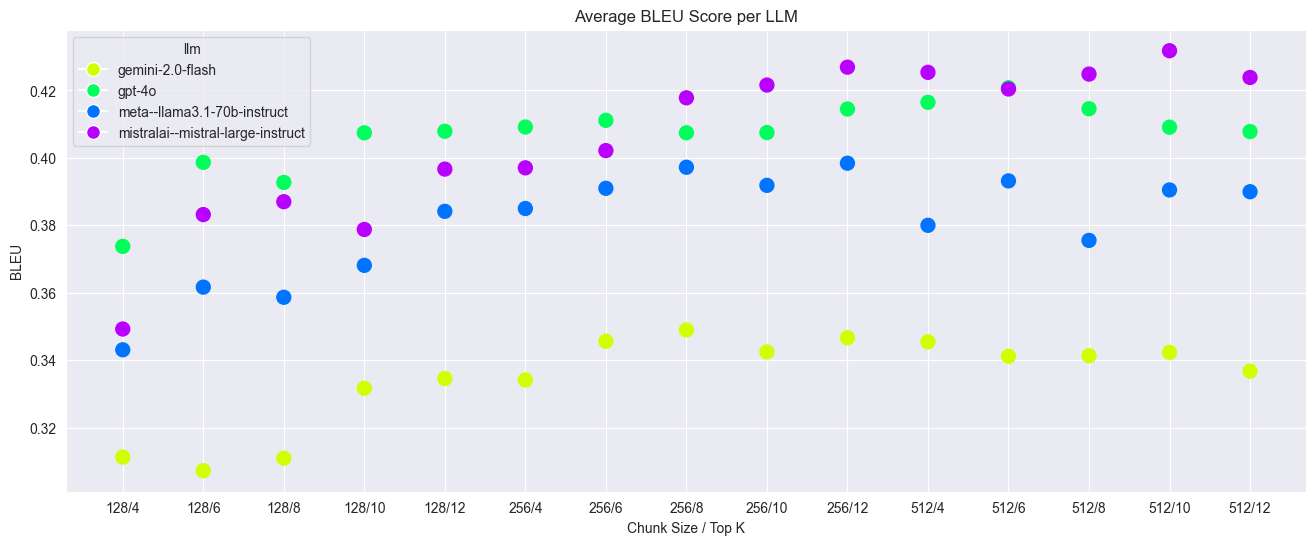

                                 llm  mean_bleu
1                             gpt-4o   0.406586
3  mistralai--mistral-large-instruct   0.405767
2        meta--llama3.1-70b-instruct   0.380547
0                   gemini-2.0-flash   0.334703


In [18]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "bleu",
    "llm",
    "Chunk Size / Top K",
    "BLEU",
    "Average BLEU Score per LLM",
)

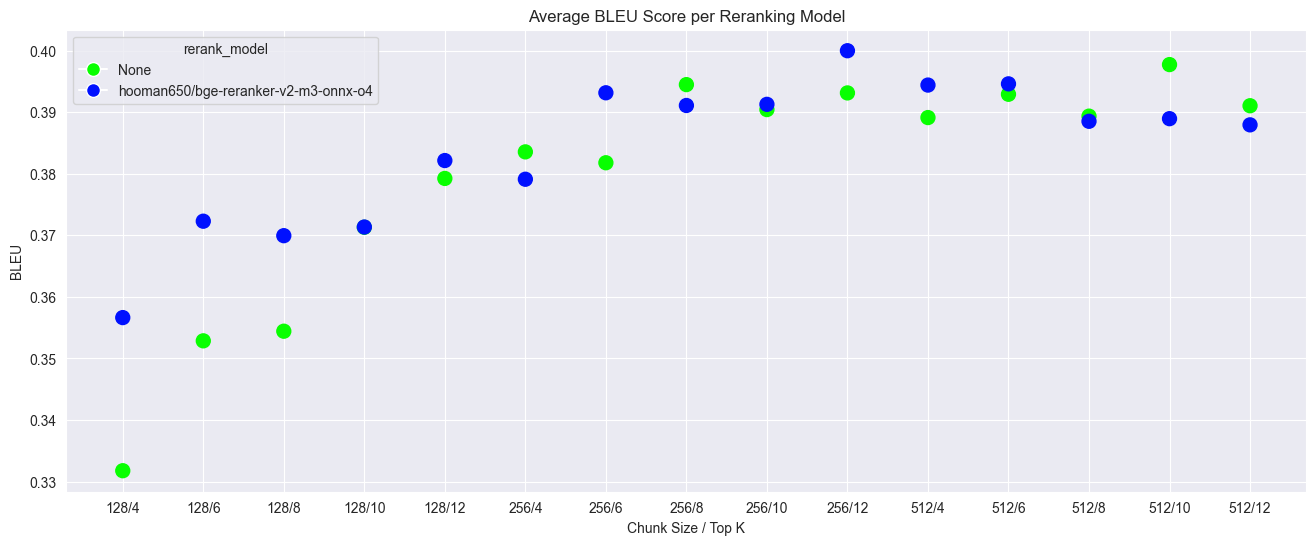

                           rerank_model  mean_bleu
1  hooman650/bge-reranker-v2-m3-onnx-o4   0.384086
0                                  None   0.379536


In [19]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "bleu",
    "rerank_model",
    "Chunk Size / Top K",
    "BLEU",
    "Average BLEU Score per Reranking Model",
)

### 2.2.2 ROUGE-1

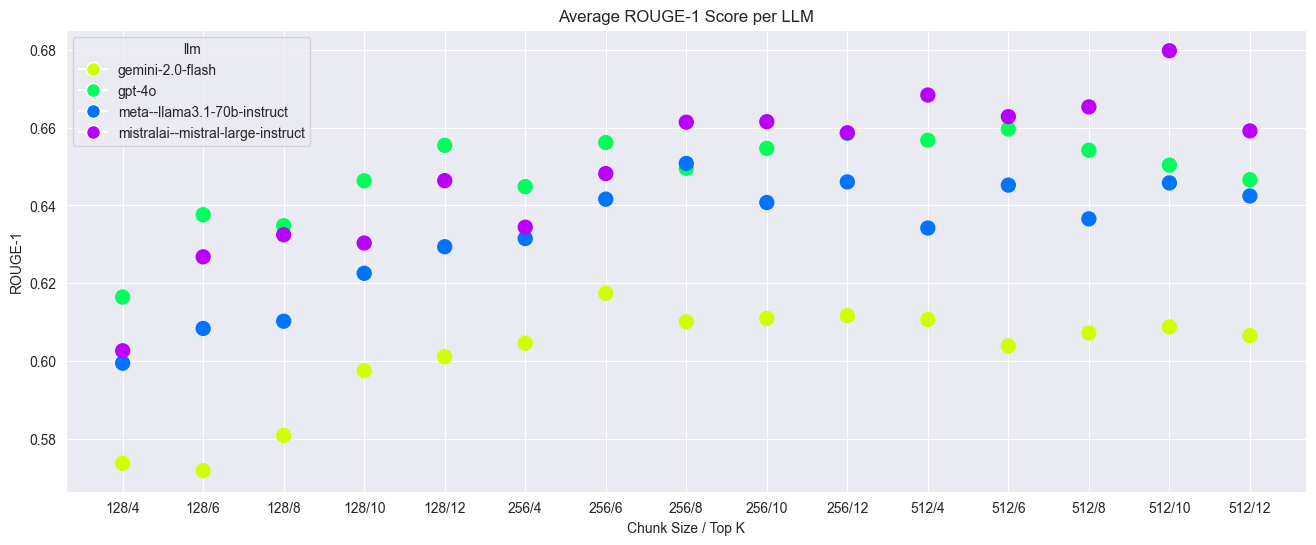

                                 llm  mean_rouge1
3  mistralai--mistral-large-instruct     0.649214
1                             gpt-4o     0.648117
2        meta--llama3.1-70b-instruct     0.632309
0                   gemini-2.0-flash     0.601085


In [20]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "rouge1",
    "llm",
    "Chunk Size / Top K",
    "ROUGE-1",
    "Average ROUGE-1 Score per LLM",
)

In [21]:
corr = data_gen["rouge1"].corr(data_gen["rouge2"])
print(f"Correlation between ROUGE-1 and ROUGE-2: {corr}")
corr = data_gen["rouge1"].corr(data_gen["rougeL"])
print(f"Correlation between ROUGE-1 and ROUGE-L: {corr}")

Correlation between ROUGE-1 and ROUGE-2: 0.9588215007149018
Correlation between ROUGE-1 and ROUGE-L: 0.9609383215544549


### 2.2.3 BERT-Score

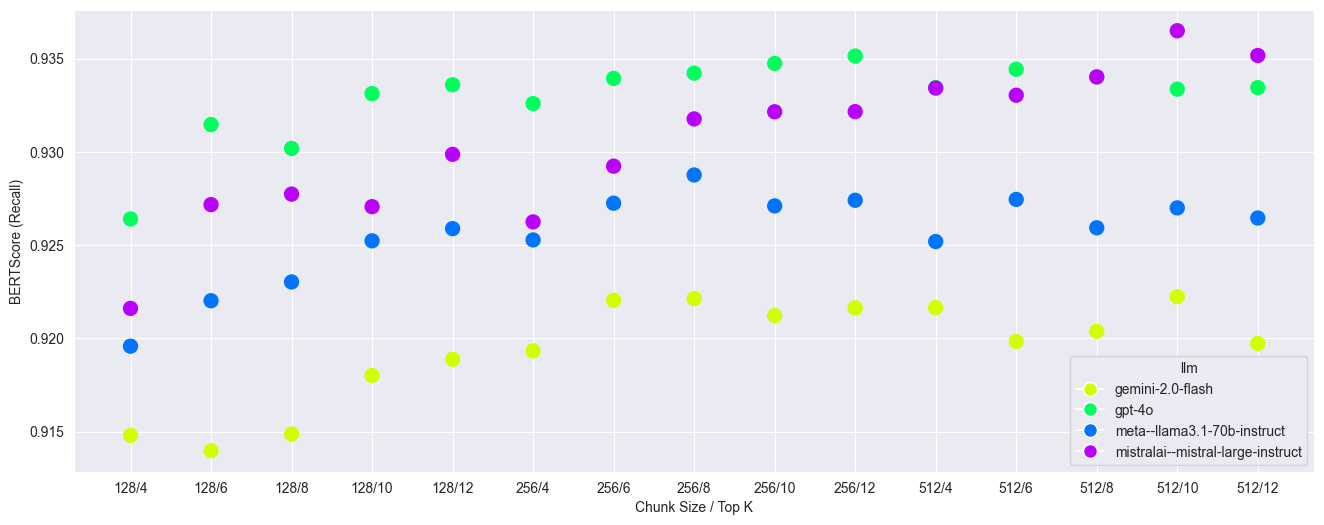

                                 llm  mean_bertscore_recall
1                             gpt-4o               0.932942
3  mistralai--mistral-large-instruct               0.930478
2        meta--llama3.1-70b-instruct               0.925571
0                   gemini-2.0-flash               0.919381


In [22]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "bertscore_recall",
    "llm",
    "Chunk Size / Top K",
    "BERTScore (Recall)",
    "",
)

## 2.3 RAG Triad
### 2.3.1 Answer Relevance

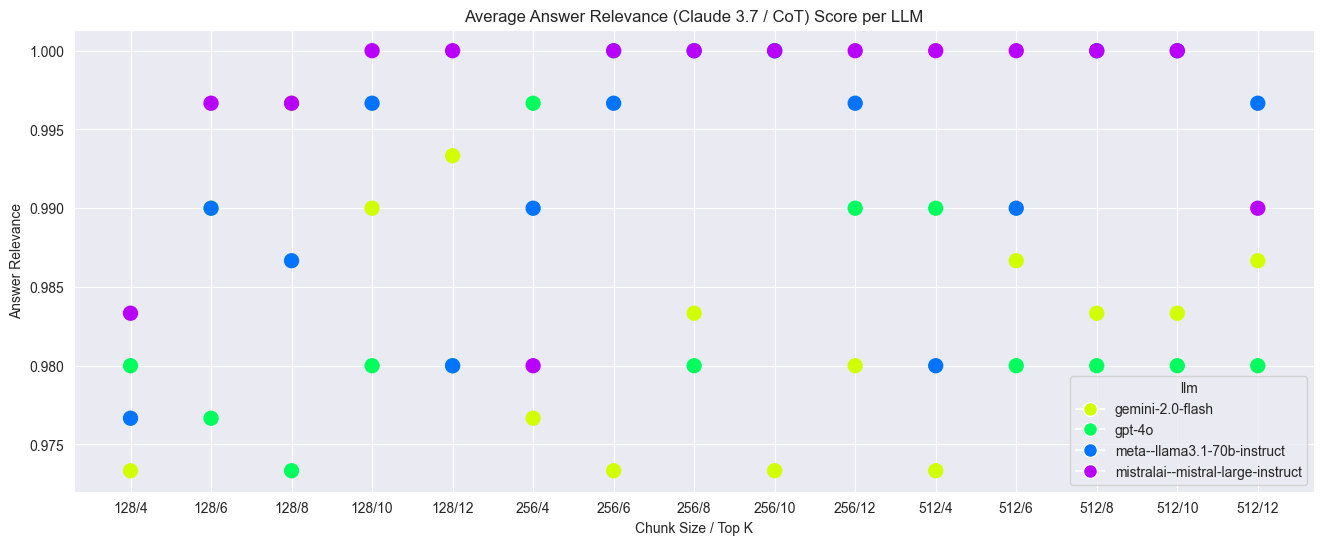

                                 llm  mean_anthropic--claude-3.7-sonnet_answer_relevance_with_cot
3  mistralai--mistral-large-instruct                                           0.996444          
2        meta--llama3.1-70b-instruct                                           0.992000          
1                             gpt-4o                                           0.984444          
0                   gemini-2.0-flash                                           0.982889          


In [23]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "anthropic--claude-3.7-sonnet_answer_relevance_with_cot",
    "llm",
    "Chunk Size / Top K",
    "Answer Relevance",
    "Average Answer Relevance (Claude 3.7 / CoT) Score per LLM",
)

### 2.3.2 Groundedness

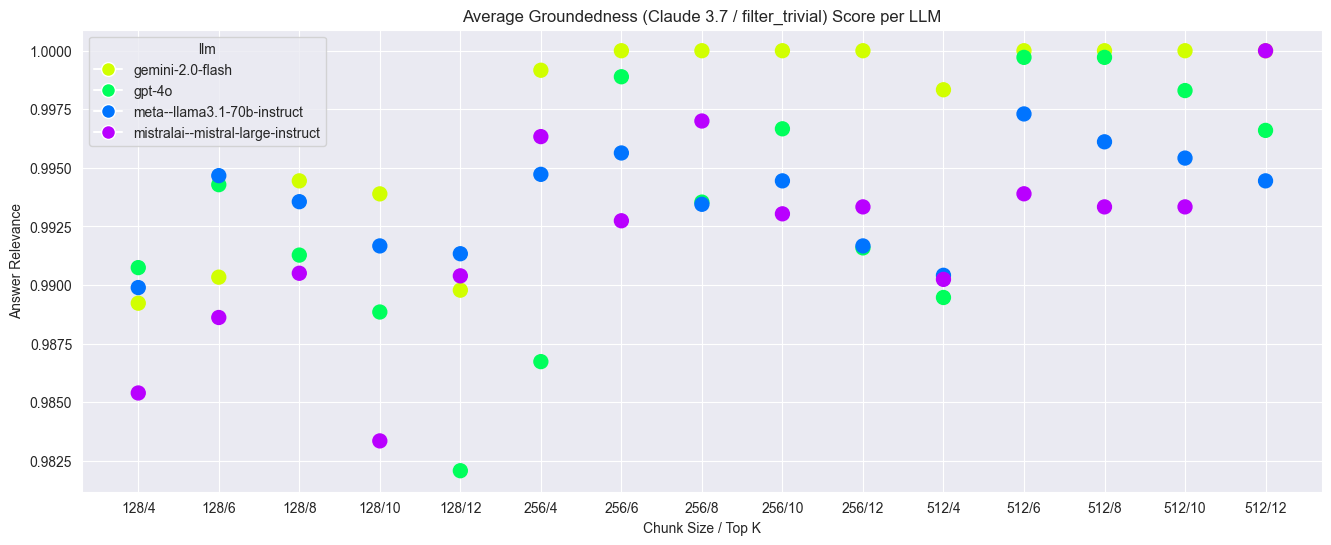

                                 llm  mean_anthropic--claude-3.7-sonnet_groundedness_filter_trivial
0                   gemini-2.0-flash                                           0.997011            
2        meta--llama3.1-70b-instruct                                           0.993647            
1                             gpt-4o                                           0.993227            
3  mistralai--mistral-large-instruct                                           0.992098            


In [24]:
plot_metric(
    data_gen,
    "chunk_top_k",
    "anthropic--claude-3.7-sonnet_groundedness_filter_trivial",
    "llm",
    "Chunk Size / Top K",
    "Answer Relevance",
    "Average Groundedness (Claude 3.7 / filter_trivial) Score per LLM",
)

### 2.3.3 RAG Triad Score

In [25]:
weight_options = [
    (1 / 3, 1 / 3, 1 / 3),
    (0.5, 0.5, 0),
    (0.5, 0.25, 0.25),
    (0.25, 0.5, 0.25),
    (0.25, 0.25, 0.5),
    (0.75, 0.25, 0),
    (0.25, 0.75, 0),
]
results = []
for w1, w2, w3 in weight_options:
    weighted_avg = (
        w1 * data_gen["anthropic--claude-3.7-sonnet_answer_relevance_with_cot"]
        + w2 * data_gen["anthropic--claude-3.7-sonnet_groundedness_filter_trivial"]
        + w3 * data_gen["gpt-4o_context_relevance_with_cot"]
    )
    corr = weighted_avg.corr(data_gen["mistralai--mistral-large-instruct_judgement"])
    results.append(
        {
            "answer_relevance": "anthropic--claude-3.7-sonnet_answer_relevance_with_cot",
            "groundedness": "anthropic--claude-3.7-sonnet_groundedness_filter_trivial",
            "context_relevance": "gpt-4o_context_relevance_with_cot",
            "weights": (w1, w2, w3),
            "correlation": corr,
        }
    )

results_sorted = sorted(results, key=lambda x: x["correlation"], reverse=True)
ranked_df = pd.DataFrame(results_sorted)
ranked_df.head(10)

,answer_relevance,groundedness,context_relevance,weights,correlation
0,anthropic--claude-3.7-sonnet_answer_relevance_...,anthropic--claude-3.7-sonnet_groundedness_filt...,gpt-4o_context_relevance_with_cot,"(0.5, 0.25, 0.25)",0.261378
1,anthropic--claude-3.7-sonnet_answer_relevance_...,anthropic--claude-3.7-sonnet_groundedness_filt...,gpt-4o_context_relevance_with_cot,"(0.3333333333333333, 0.3333333333333333, 0.333...",0.251360
2,anthropic--claude-3.7-sonnet_answer_relevance_...,anthropic--claude-3.7-sonnet_groundedness_filt...,gpt-4o_context_relevance_with_cot,"(0.25, 0.25, 0.5)",0.234668
3,anthropic--claude-3.7-sonnet_answer_relevance_...,anthropic--claude-3.7-sonnet_groundedness_filt...,gpt-4o_context_relevance_with_cot,"(0.25, 0.5, 0.25)",0.225138
4,anthropic--claude-3.7-sonnet_answer_relevance_...,anthropic--claude-3.7-sonnet_groundedness_filt...,gpt-4o_context_relevance_with_cot,"(0.75, 0.25, 0)",0.218867
5,anthropic--claude-3.7-sonnet_answer_relevance_...,anthropic--claude-3.7-sonnet_groundedness_filt...,gpt-4o_context_relevance_with_cot,"(0.5, 0.5, 0)",0.208496
6,anthropic--claude-3.7-sonnet_answer_relevance_...,anthropic--claude-3.7-sonnet_groundedness_filt...,gpt-4o_context_relevance_with_cot,"(0.25, 0.75, 0)",0.148075


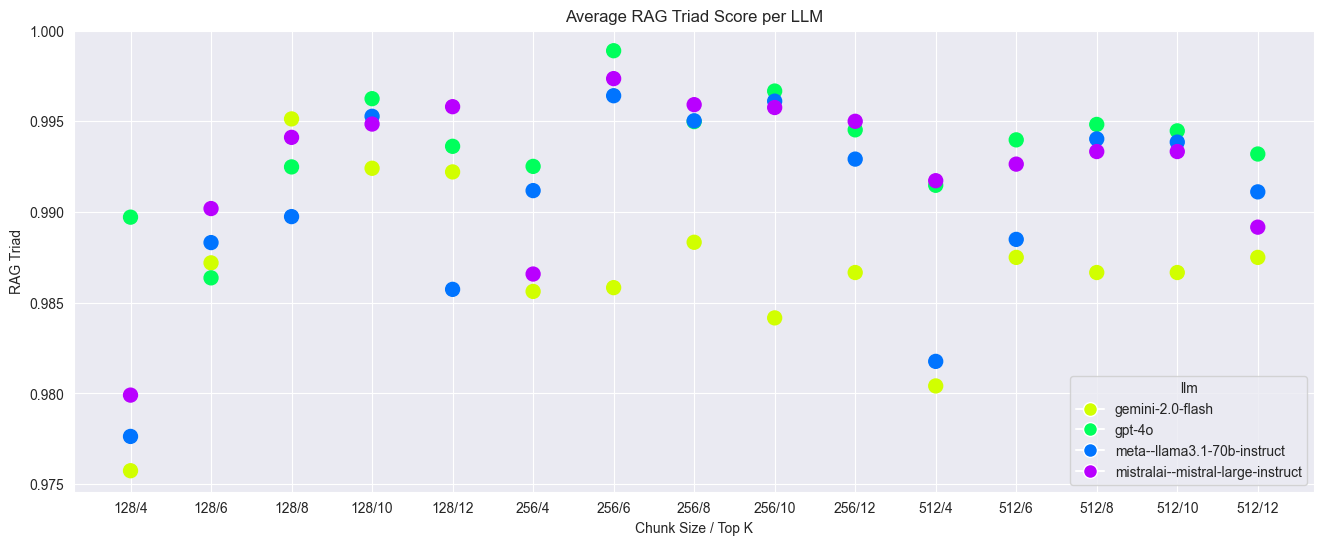

                                 llm  mean_rag_triad
1                             gpt-4o        0.993598
3  mistralai--mistral-large-instruct        0.992379
2        meta--llama3.1-70b-instruct        0.990507
0                   gemini-2.0-flash        0.986805


In [26]:
data_gen["rag_triad"] = (
    data_gen["anthropic--claude-3.7-sonnet_answer_relevance_with_cot"] * 0.5
    + data_gen["anthropic--claude-3.7-sonnet_groundedness_filter_trivial"] * 0.25
    + data_gen["gpt-4o_context_relevance_with_cot"] * 0.25
)
plot_metric(
    data_gen,
    "chunk_top_k",
    "rag_triad",
    "llm",
    "Chunk Size / Top K",
    "RAG Triad",
    "Average RAG Triad Score per LLM",
)

### 2.4 Correlation Analysis

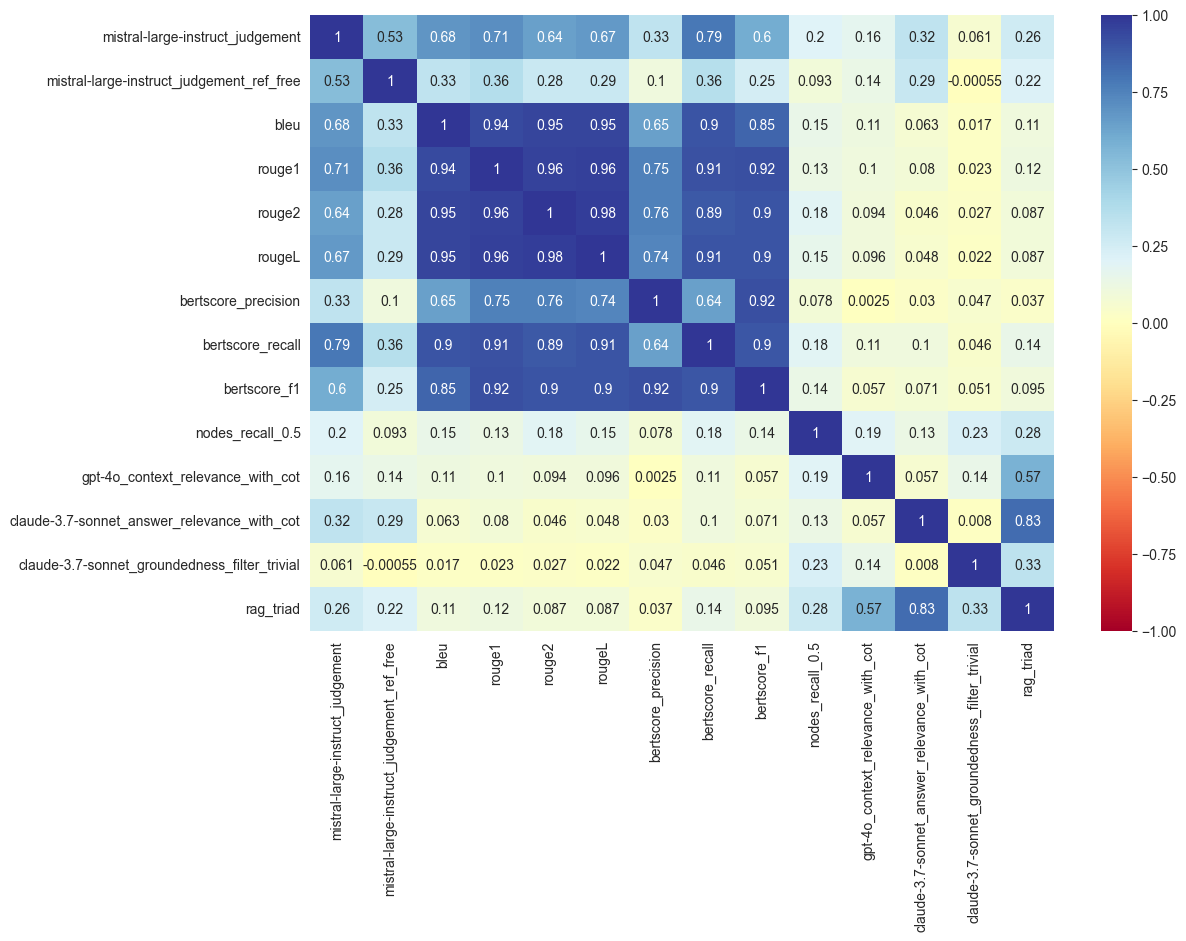

In [27]:
plt.figure(figsize=(12, 8))
ax1 = plt.gca()
cols = [
    "mistralai--mistral-large-instruct_judgement",
    "mistralai--mistral-large-instruct_judgement_ref_free",
    "bleu",
    "rouge1",
    "rouge2",
    "rougeL",
    "bertscore_precision",
    "bertscore_recall",
    "bertscore_f1",
    "nodes_recall_0.5",
    "gpt-4o_context_relevance_with_cot",
    "anthropic--claude-3.7-sonnet_answer_relevance_with_cot",
    "anthropic--claude-3.7-sonnet_groundedness_filter_trivial",
    "rag_triad",
]
labels = [j.split("--")[-1] for j in cols]
corr = data_gen[cols].corr()
sns.heatmap(
    corr,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=labels,
    yticklabels=labels,
    ax=ax1,
)
plt.show()